<a href="https://colab.research.google.com/github/emmanuel010/Style_transfer_using_tensorflow_2.0/blob/master/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install tensorflow-gpu==2.0

     |████████████████████████████████| 380.8MB 62kB/s 
     |████████████████████████████████| 450kB 42.2MB/s 
     |████████████████████████████████| 3.8MB 20.1MB/s 
ERROR: tensorflow 1.15.0rc3 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.15.0rc3 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
import IPython.display as display
import os as os
%matplotlib inline
print(tf.__version__)

2.0.0


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
#from tf.keras.applications.vgg16 import VGG16 #the model we will be using to get the features of content image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input


In [0]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor,dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
    tensor = tensor[0]
    return Image.fromarray(tensor)

In [0]:
def load_img(filename):
    image=plt.imread(filename)
    img=tf.image.convert_image_dtype(image,tf.float32) #converting image to a machine readable form
    img=tf.image.resize(img, [400,400]) #resizing to fit the model
    img=img[tf.newaxis, :] #added 1 more dimension to the image for defininig batch size -keras preprocess_input
    return img

In [0]:
style=load_img('/the-scream.jpg')
content=load_img('/nitc-main.jpg')

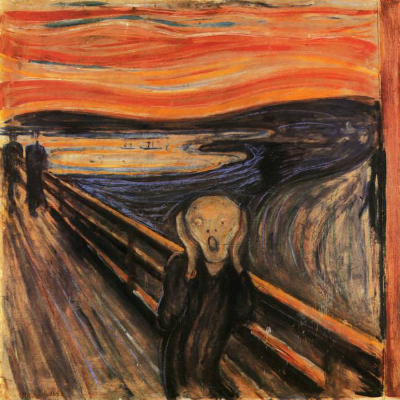

In [88]:
tensor_to_image(style)

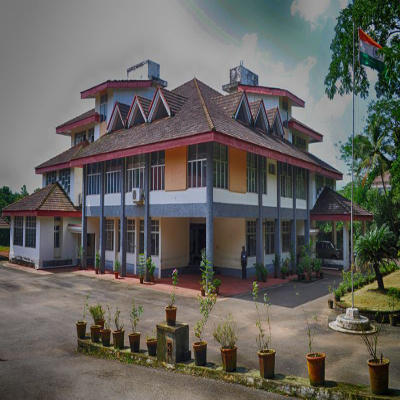

In [105]:
#content=tf.image.rot90(tf.image.rot90(tf.image.rot90(content)))
tensor_to_image(content)

In [90]:
content.shape

TensorShape([1, 400, 400, 3])

In [0]:
    vgg=tf.keras.applications.VGG19(include_top=False,weights='imagenet') #doesnt include the 3 fully-connected layers at the top
    vgg.trainable= False                                                #the values of the weights will be fixed thoroughout the code

In [92]:
for layer in vgg.layers:
    print(layer.name)

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
content_layer=['block5_conv2']
style_layers=['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
num_style_layers = len(style_layers)
num_content_layers=len(content_layer)


In [0]:
def mymodel(layer_names, model):

    outputs=[model.get_layer(names).output for names in layer_names]   #get the outputs from each layer in out model
    model=Model([vgg.input],outputs)                                   #Model is a neural network in keras
    return model

In [0]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [0]:
class my_style_model(Model):
    def __init__ (self,style_layers,content_layer):
        super(my_style_model, self).__init__()

        
        self.vgg= mymodel(style_layers+content_layer, vgg)
        self.style_layers=style_layers
        self.content_layer=content_layer
        self.num_style_layers=len(style_layers)
        self.vgg.trainable=False
        
        
    def call(self,inputs):
        inputs=inputs*255   #inputs are betweeen 0.0 and 1.0
        process_input=preprocess_input(inputs)
        outputs=self.vgg(process_input)
            
        style_outputs, content_outputs =(outputs[:self.num_style_layers],
                                             outputs[self.num_style_layers:])
            
        style_outputs=[gram_matrix(i) for i in style_outputs]
            
        style_dict={style_name:value for style_name, value in zip(self.style_layers,style_outputs)}
            
        content_dict={content_name:value for content_name,value in zip(self.content_layer,content_outputs)}
            
        return {'content': content_dict, 'style':style_dict}
            
            

In [0]:
extractor = my_style_model(style_layers, content_layer)
style_targets = extractor(style)['style']
content_targets = extractor(content)['content']

In [0]:
optimize= tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [0]:
style_weight=1e-2
content_weight=1e3

In [0]:
def total_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss

    return loss    
    

In [0]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs=extractor(image)
        loss=total_loss(outputs)
        loss += 30*tf.image.total_variation(image)

    grad=tape.gradient(loss,image)
    optimize.apply_gradients([(grad,image)])
    image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))



In [0]:
image = tf.Variable(content)


0


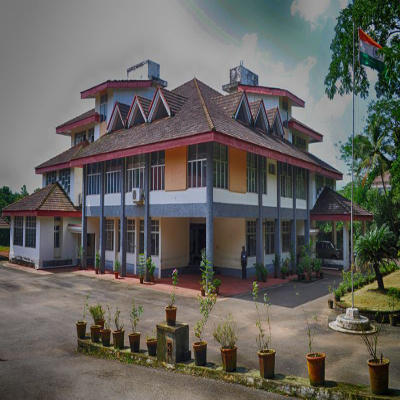

100


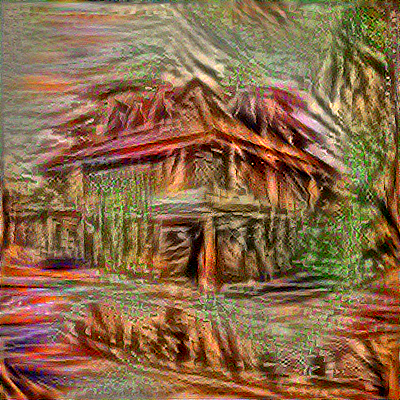

200


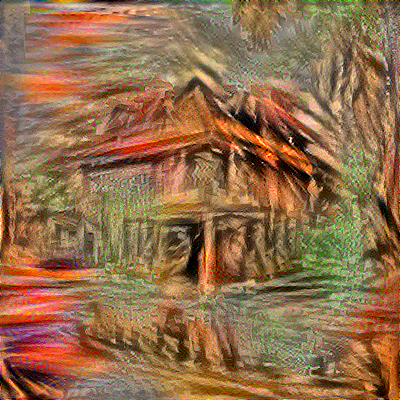

300


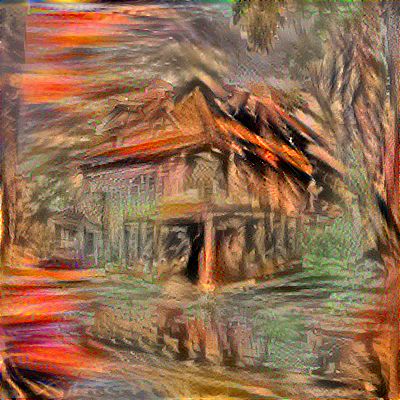

400


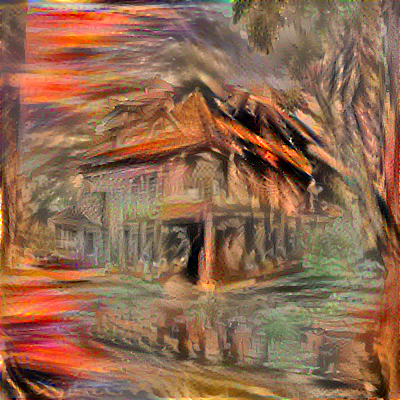

500


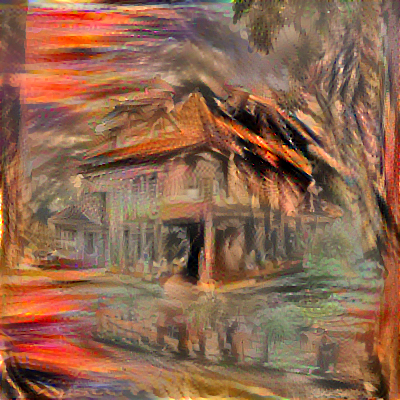

600


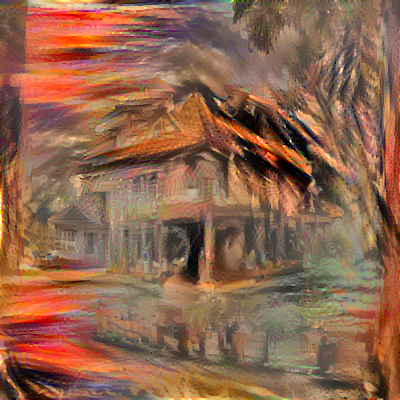

700


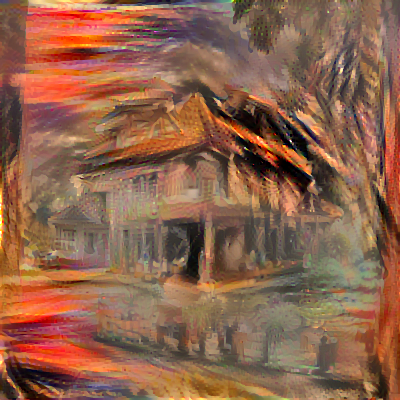

800


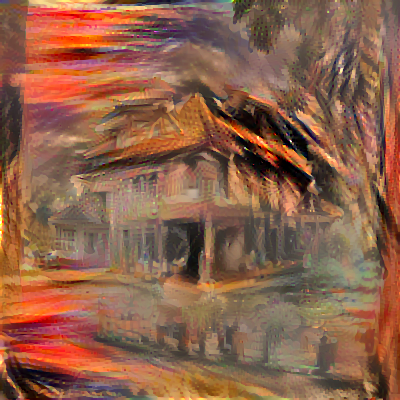

KeyboardInterrupt: ignored

In [127]:
for i in range(1000):
    if(i%100==0):
        print (i)
        display.display(tensor_to_image(image))
    train_step(image)


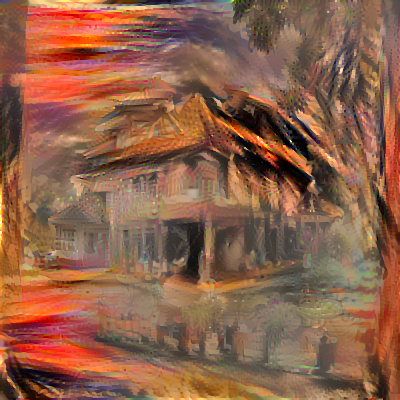

In [128]:
tensor_to_image(image)

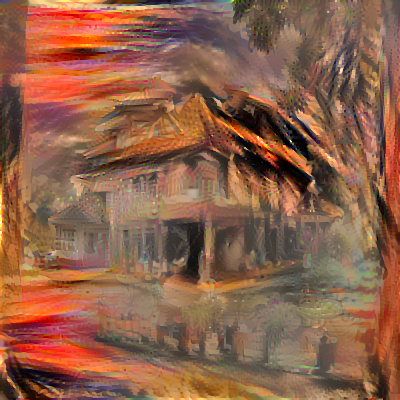

In [129]:
tensor_to_image(image)

In [0]:
im=tensor_to_image(image)

In [0]:
im.save(os.path.join("/tensor2"+str(i)+".jpeg"))


In [0]:
vgg.inputs

[<tf.Tensor 'input_2:0' shape=(None, None, None, 3) dtype=float32>]